In [1]:
import os
from classification_models.tfkeras import Classifiers

# Import the ResNet34 model
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [2]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
# Normalice the angular momentum
from sklearn.preprocessing import normalize

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

# Change parameters here...
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)
data_dir = 'data/' # Change
sizex = 500
sizey = 500
sizez = 3
rand_seed = 123
num_datasets = -1
batch_size = 128
buf_size = 895
nb_epochs = 200
validation_ratio = 0.1

In [3]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [4]:
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'x_dust' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [5]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images)
data_dict['x_dust'].shape

(895, 500, 500, 3)

In [6]:
# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

def map_to_180(ang_norm):
  angle = ang_norm*180
  return angle

# computing the normaliced angle and the come back to cartesian to check the conversion
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)
data_dict['y_angle'] = cart_to_esf(normalize(data_dict['y'], axis=1))
data_dict['y_angle_norm'] = map_to_1(break_degeneracy(data_dict['y_angle']))
data_dict['y_reverse']= esf_to_cart(map_to_180(data_dict['y_angle_norm']))

In [7]:
# check the shape of our dictionary in te labels entry
print(data_dict['y_angle'].shape)

(895, 2)


In [8]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

In [9]:
# functions to visualice the data 
def viz(img, label, pred=[0,0,0], id=None):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    ax.arrow(250,250,100*label[0],100*label[1], head_width=7, head_length=10, fc='g', ec='g')
    if sum(abs(pred)) > 0: ax.arrow(250,250,100*pred[0],100*pred[1], head_width=7, head_length=10, fc='r', ec='r')
        
    display(Markdown("#### **cartesian label:** {}".format(label)))
    if sum(abs(pred)) > 0: display(Markdown("#### **inverse from angle:** {}".format(pred)))
    if id: display(Markdown("#### **ID:** {}".format(id)))
    plt.show()
        
# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,), y_angle: (2,), y_angle_norm: (2,), y_reverse: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64, y_angle: tf.float64, y_angle_norm: tf.float64, y_reverse: tf.float64}>


<TakeDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,), y_angle: (2,), y_angle_norm: (2,), y_reverse: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64, y_angle: tf.float64, y_angle_norm: tf.float64, y_reverse: tf.float64}>


#### **cartesian label:** [0.73639    0.0919113  0.67028507]

#### **inverse from angle:** [0.73639    0.0919113  0.67028507]

#### **ID:** b'g5.38e11_x73_y33_z282'

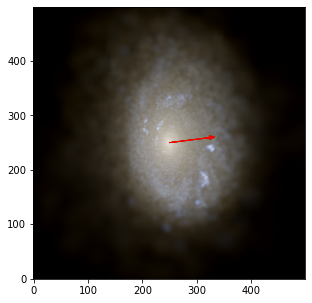

#### **cartesian label:** [0.91321264 0.07612517 0.40030942]

#### **inverse from angle:** [0.91321264 0.07612517 0.40030942]

#### **ID:** b'g3.54e09_x174_y289_z10'

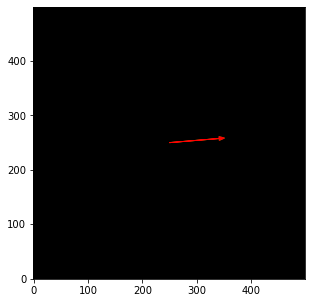

#### **cartesian label:** [-0.86259336  0.32798186  0.38517605]

#### **inverse from angle:** [-0.86259336  0.32798186  0.38517605]

#### **ID:** b'g3.59e11_x327_y67_z51'

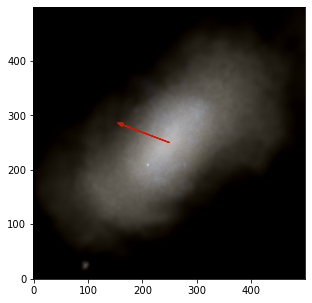

#### **cartesian label:** [ 0.86984429 -0.45869166  0.18158434]

#### **inverse from angle:** [-0.86984429  0.45869166  0.18158434]

#### **ID:** b'g1.23e10_x250_y166_z131'

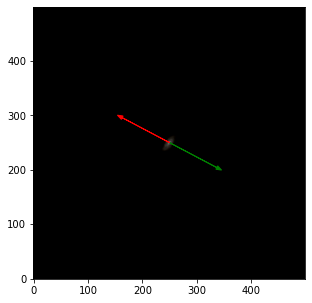

#### **cartesian label:** [-0.49327222  0.23212117 -0.83833303]

#### **inverse from angle:** [-0.49327222  0.23212117 -0.83833303]

#### **ID:** b'g5.38e11_x207_y331_z254'

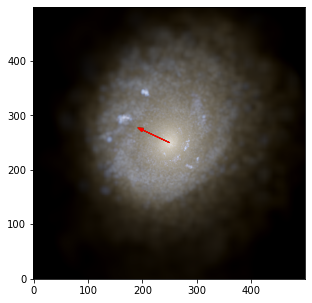

#### **cartesian label:** [-0.61369093  0.6727376  -0.41328872]

#### **inverse from angle:** [-0.61369093  0.6727376  -0.41328872]

#### **ID:** b'g3.55e11_x221_y111_z121'

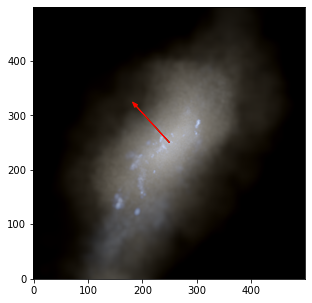

#### **cartesian label:** [-0.19316571  0.37082021  0.90839385]

#### **inverse from angle:** [-0.19316571  0.37082021  0.90839385]

#### **ID:** b'g5.36e11_x334_y80_z22'

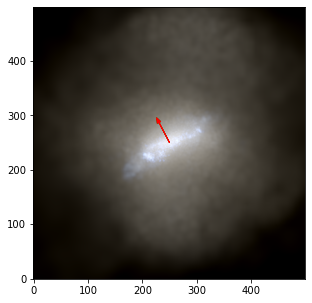

#### **cartesian label:** [-0.32922093  0.7162336   0.6153235 ]

#### **inverse from angle:** [-0.32922093  0.7162336   0.6153235 ]

#### **ID:** b'g1.23e10_x43_y149_z285'

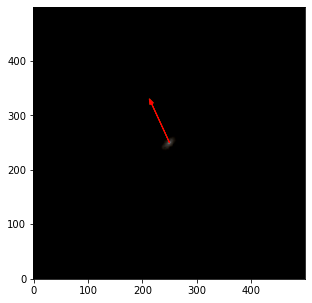

#### **cartesian label:** [-0.34257352 -0.90712284  0.2444822 ]

#### **inverse from angle:** [0.34257352 0.90712284 0.2444822 ]

#### **ID:** b'g5.36e11_x322_y6_z166'

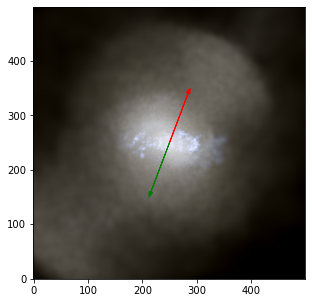

#### **cartesian label:** [-0.72355164  0.60583655 -0.33080975]

#### **inverse from angle:** [-0.72355164  0.60583655 -0.33080975]

#### **ID:** b'g4.94e10_x123_y288_z247'

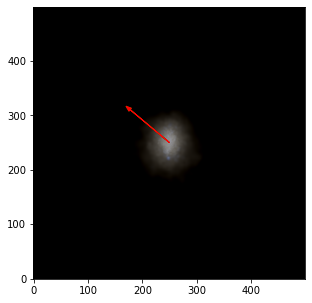

#### **cartesian label:** [0.66018449 0.69187025 0.29235593]

#### **inverse from angle:** [0.66018449 0.69187025 0.29235593]

#### **ID:** b'g1.95e10_x123_y47_z338'

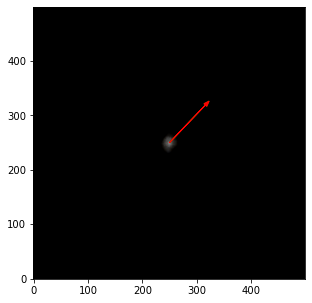

In [10]:
# visualice the data
elem = dataset.take(1)
print(elem)
for e in elem:
    viz(e['x_nodust'], e['y_norm'],e['y_reverse'], e['ids'])

real_dataset = dataset.batch(batch_size).shuffle(10, seed=rand_seed)
for idx in range(1,5):
    elements = real_dataset.take(idx)
    for elem in elements:
        viz(elem['x_nodust'][idx], elem['y_norm'][idx],elem['y_reverse'][idx], elem['ids'][idx]) # select any index within the batch, e.g. 2

In [11]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
ds_size = len(data_dict['y_angle_norm'])

input_ds = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_angle_norm'].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False)
)

val_size = math.floor(ds_size * validation_ratio)
validation_ds = ( input_ds.take(val_size).batch(batch_size) )
train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=buf_size, reshuffle_each_iteration=True).batch(batch_size) )

print(train_ds)
print(validation_ds)

<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [12]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

Reusing TensorBoard on port 6006 (pid 8078), started 0:03:26 ago. (Use '!kill 8078' to kill it.)

In [15]:
# Build model
base_model = ResNet34(input_shape=(sizey,sizex,3), weights='imagenet', include_top=False)

# redefine the output to be from tensorflow probability a PDF
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x_2 = tf.keras.layers.Dense(tfpl.IndependentNormal.params_size(2), activation=None)(x)
#tfpl.IndependentNormal(input_shape, tfd.Normal.mean),
output = tfpl.IndependentNormal(2, tfd.Normal.sample)(x_2)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
snapshot_weights = 'best_weights_angles_nll_s.hdf5'
last_snapshot_weights = 'last_weights_angles_nll.hdf5'
#if os.path.isfile(last_snapshot_weights):
#    model.load_weights(last_snapshot_weights)

negloglik = lambda y, p_y: tf.reduce_prod(-p_y.log_prob(y))

#model.compile(optimizer='SGD', loss=negloglik, metrics=['accuracy'])
model.compile(optimizer='SGD', loss=negloglik, metrics=['accuracy'])
# model.summary()

In [16]:
# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer_1 = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)
checkpointer_2 = tf.keras.callbacks.ModelCheckpoint(filepath=last_snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=False)

callbacks = [
    tensorboard_callback,
    checkpointer_1,
    checkpointer_2
]

model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

model.save('models/trained.h5') # Not really needed as we have the weights already

Epoch 1/200
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
7/7 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4727 

InvalidArgumentError: Nan in summary histogram for: bn_data_1/beta_0 [Op:WriteHistogramSummary]

In [ ]:
model.save('models/trained_nll_s.h5')

In [ ]:
domain = np.linspace(0,1,100)
val_ex, = validation_ds.take(1)
images, labels = val_ex[0], val_ex[1]
outputs = np.array([model.predict(val_ex)])

for i in range(len(domain)):
    outputs = np.append(outputs, [model.predict(val_ex)],axis=0)

In [ ]:
for i in range(5):
    plt.vline()
    plt.hist(np.array(outputs[:,i,0]),alpha=0.3)
    plt.hist(np.array(outputs[:,i,1]),alpha=0.3)
    plt.show()

In [ ]:
means = np.mean(outputs,axis=0)

print(means)
print(labels)

In [ ]:
labels = esf_to_cart(map_to_180(labels))
predictions = esf_to_cart(map_to_180(means))

#print(labels)
#print(predictions)

for img,label,pred,i in zip(images,labels,predictions,range(10)):
    viz(img, label, pred)